## Imports

In [38]:
import numpy as np
from PIL import Image
import pathlib
import IPython.display as display
from cv2 import imread
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import defaultdict
from tensorflow.keras.layers import (Conv2D, Dense, Dropout, Flatten, Input,
                                     MaxPooling2D, Reshape, UpSampling2D, Lambda)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow_similarity.api.engine.simhash import SimHash
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.auto import tqdm

## Read in emoji dataset

In [39]:
directory = "emoji_dataset"
data_dir = pathlib.Path(directory)

In [41]:
all_images_paths = list(data_dir.glob('*.png'))

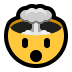

In [43]:
display.display(Image.open(str(all_images_paths[95])))

In [44]:
num_images = len(all_images_paths)
x_targets = []
y_targets = []

In [45]:
for image_path in all_images_paths:
    path_str = str(image_path)
    y_target = path_str.split("__")[0].split("/")[1]
    x_target = imread(path_str)
    x_target = tf.image.rgb_to_grayscale(x_target).numpy()
    x_target = np.max(x_target) - x_target
    x_target = x_target / np.max(x_target)
    x_targets.append(x_target)
    y_targets.append(y_target)

In [49]:
icon_size = 32 # original size 72
num_augment = 50
num_shots = 4 # at most 5
num_unseen_classes = 20 # original classes ~1700 

In [50]:
x_targets = np.asarray(x_targets)
y_targets = np.asarray(y_targets)

In [51]:
def label_to_number(y_targets):
    uniques = np.unique(y_targets)
    unique_dicts = dict()
    for i, label in enumerate(uniques):
        unique_dicts[label] = i
    result = np.zeros(y_targets.shape, dtype=int)
    for i, target in enumerate(y_targets):
        result[i] = unique_dicts[target]
    return result

In [52]:
y_targets = label_to_number(y_targets)

## Split and Augment Emoji Data

In [53]:
def one_shot_learning_split(x_data, y_data, num_unseen_classes=5, num_shots=1, new_size=32, num_augment=20):
    
    x_data = tf.image.resize_with_pad(x_data, new_size, new_size)
    datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest') # FIXME: vertical_flip = True

    datagen.fit(x_data)
    
    if num_augment > 0:
        print("performing data augmentation")
        batch_size = 64 * 4
        new_x_train = np.zeros((len(x_data) * num_augment, new_size, new_size, 1))
        new_y_train = np.empty(len(new_x_train), dtype=object)

        num_steps = int(len(new_x_train) / batch_size)

        image_generator = datagen.flow(x=x_data, y=y_data, batch_size=batch_size)


        # pbar that we want to update
        pbar = tqdm(total=len(new_x_train))
        idx = 0
        while idx < len(new_x_train):
            x_train_batch, y_train_batch = next(image_generator)

            batch_size = len(x_train_batch)
            batch_size = min(batch_size, len(new_x_train) - idx)
            new_x_train[idx:idx+batch_size] = x_train_batch
            new_y_train[idx:idx+batch_size] = y_train_batch

            idx += batch_size
            pbar.update(batch_size)

        x_data = new_x_train
        y_data = new_y_train
    
    unique_classes = np.unique(y_data)
    test_classes = np.random.choice(
        unique_classes,
        num_unseen_classes,
        replace=False)
    
    # classes that are not selected are available for training
    available_train_classes = np.setdiff1d(
        unique_classes, test_classes, assume_unique=True)
    
    x_train = []
    x_test = []
    x_target = []
    y_train = []
    y_test = []
    y_target = []
    
    seen = defaultdict(int)

    for image, label in zip(x_data, y_data):
        if label in test_classes:
            if seen[label] < num_shots:
                x_target.append(image)
                y_target.append(label)
                seen[label] += 1
            else:
                x_test.append(image)
                y_test.append(label)
        elif label in available_train_classes:
            x_train.append(image)
            y_train.append(label)

    x_train = {"image": np.array(x_train)}
    y_train = np.array(y_train)
    x_test = {"image": np.array(x_test)}
    y_test = np.array(y_test)
    x_target = {"image": np.array(x_target)}
    y_target = np.array(y_target)

    return (x_train, y_train), (x_test, y_test), (x_target, y_target)

In [54]:
(x_train, y_train), (x_test, y_test), (x_target, y_target) = one_shot_learning_split(x_targets, y_targets, num_unseen_classes, num_shots, icon_size, num_augment)

performing data augmentation


### Normalize the training data

In [31]:
x_train_data = x_train["image"]
x_train_data = (np.max(x_train_data) - x_train_data) / np.max(x_train_data)
x_train["image"] = x_train_data

In [57]:
def model_fn():
    """A simple tower model for mnist dataset.
    
    Returns:
        model: A tensorflow model.
    """
    
    i = Input(shape=(icon_size, icon_size, 1), name="image")
    o = Conv2D(32, kernel_size=(5, 5), activation='relu')(i)
    o = Conv2D(32, kernel_size=(5, 5), activation='relu')(o)
    o = Conv2D(64, (3, 3), padding='same', activation='relu')(o)
    o = Conv2D(64, (3, 3), padding='same', activation='relu')(o)

    o = tf.keras.layers.GlobalMaxPool2D()(o)
    o = Dense(64)(o)
    o = Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name="l2_norm")(o)
    model = Model(inputs=i, outputs=o)
    return model

In [58]:
model = model_fn()

In [61]:
moirai = SimHash(
    model,
    strategy="triplet_loss",
    batch_size=256,
    optimizer=Adam(lr=.001))

moirai.fit(
    x_train,
    y_train,
    epochs=20)

moirai.save('new_smily_model.h5')

Model: "triplet_loss"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_image (InputLayer)       [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
anchor_idx (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
neg_image (InputLayer)          [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
neg_idx (InputLayer)            [(None, 1)]          0                                            
_______________________________________________________________________________________